# Predict on all merged data

In [24]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import autosklearn.regression
from tpot import TPOTRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error


from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters



os.chdir("/home/cernerrood246/University/DataMining")
random_state = 42

#Relevant Models: LR, SVM, LightGBM, CatBoost, XGBoost 

## Feature engineering

In [2]:
participants_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17'] 

Merged_all_list = []
for participant in participants_list:
    df = pd.read_pickle(f"merged_dataset/{participant}/ALL.pkl")
    df['Participant'] = participant
    Merged_all_list.append(df)

feature_Merged_all_list = []
for participant_temp in Merged_all_list:
    participant = participant_temp.copy()
    #add lag features
    participant.rename(columns={"value__bpm": "valuebpm", "value__confidence" : "valueconfidence"}, inplace=True)
    to_feature_engineer_columns = ["valuebpm", "valueconfidence", "X", "Y", "Z", "Magnitude",]
    all_columns = to_feature_engineer_columns.copy()
    all_columns.extend(['Activity','BMI', 'Fat', 'Muscle',
       'Water', 'Bone', 'Weight', 'Height', 'Age', 'Gender_F', 'Gender_M', "active energy (kJ)"])
    #fill missing values 
    participant.ffill(inplace=True)
    participant.bfill(inplace=True)

    extract_features_colums = to_feature_engineer_columns.copy()
    extract_features_colums.extend(['Time[s]'])

    participant[to_feature_engineer_columns] = participant[to_feature_engineer_columns].bfill()
    participant[to_feature_engineer_columns] = participant[to_feature_engineer_columns].ffill()
    for column in to_feature_engineer_columns:
        for i in range(1, 10, 2):
            participant[f"{column}_lag_{i}"] = participant[column].shift(i)
            all_columns.append(f"{column}_lag_{i}")
            participant[f"{column}_lag_{i}"] = participant[f"{column}_lag_{i}"].bfill()
            participant[f"{column}_lag_{i}"] = participant[f"{column}_lag_{i}"].ffill()

    participant_features = extract_features(participant[extract_features_colums].copy(), column_id='Time[s]',
                    default_fc_parameters = MinimalFCParameters(),
                    n_jobs = 4,
                    )
    
    # merge participant_features with participant 
    participant = participant.merge(participant_features, left_on='Time[s]', right_index=True)
    feature_Merged_all_list.append(participant)

all_columns.extend(participant_features.columns) 
    

Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


## Predicting

### Setup

In [20]:
n_splits = 17
scoring_function = "neg_mean_absolute_error"

parameters_17_30 = dict([('colsample_bytree', 0.7071456869410196),
             ('learning_rate', 0.031606214394703507),
             ('max_depth', 3),
             ('min_child_weight', 4.960626120328568),
             ('subsample', 1.0)])

parameters = parameters_17_30


all_merged_df = pd.concat(feature_Merged_all_list, axis=0)

all_merged_df_selected = all_merged_df[all_columns].copy()
# all_merged_df_selected = select_features(all_merged_df[all_columns], all_merged_df["MET"])

X = all_merged_df_selected.to_numpy()
y = all_merged_df["MET"].to_numpy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Get the list of participants
participants = all_merged_df['Participant']

# Initialize the GroupKFold object
group_kfold = GroupKFold(n_splits=n_splits)
cv=group_kfold.get_n_splits(X, y, participants)

model = XGBRegressor(**parameters, random_state = 42)



In [21]:
cv = [split for split in group_kfold.split(X, y, participants)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)



In [22]:
for i,group in enumerate(cv):
    print(f"Fold {i}")
    print(f"Train size: {group[0].size}")
    print(f"Test size: {group[1].size}")
    print(f"Train participants: {participants.iloc[group[0]].unique()}")
    print(f"Test participants: {participants.iloc[group[1]].unique()}")

Fold 0
Train size: 25854
Test size: 1802
Train participants: ['P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P1']
Fold 1
Train size: 25630
Test size: 2026
Train participants: ['P1' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P2']
Fold 2
Train size: 26159
Test size: 1497
Train participants: ['P1' 'P2' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P3']
Fold 3
Train size: 25836
Test size: 1820
Train participants: ['P1' 'P2' 'P3' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P4']
Fold 4
Train size: 25937
Test size: 1719
Train participants: ['P1' 'P2' 'P3' 'P4' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P5']
Fold 5
Train size: 26006
Test size: 1650
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P7' 'P8' 'P9' 'P10' 'P

### Simple

In [23]:
# Perform cross-validation and calculate mean squared error
scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_function, n_jobs=-1)
print("Cross-validation scores:", -scores)
mae = -scores.mean()

print("Mean absolute error:", mae)

Cross-validation scores: [0.68826225 0.95439594 1.66773343 0.50835207 0.59604127 0.85772668
 0.63639955 0.87852294 0.79576615 0.47520622 0.51386637 1.50554777
 0.79146288 0.08522822 1.00498496 0.67491092 1.03895701]
Mean squared error: 0.8043155654392102


### Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

parameters = {    
        'max_depth': [2,3,7],
        'min_child_weight': [0.3,0.5, 2],
        'subsample': [0.3, 0.5],
        'colsample_bytree': [0.6,0.8],
        'learning_rate':[0.03, 0.05, 0.07],
    }
clf = GridSearchCV(XGBRegressor(random_state = 42), parameters, cv=group_kfold.get_n_splits(X, y, participants), scoring=scoring_function, n_jobs=-1, verbose=3)
clf.fit(X, y)

print("val. score: %s" % clf.best_score_)
sorted(clf.cv_results_.keys())

Fitting 17 folds for each of 108 candidates, totalling 1836 fits


KeyboardInterrupt: 

In [ ]:
clf.cv_results_["params"]

In [11]:
opt = BayesSearchCV(
    model,
    {
        'max_depth': Integer(3, 7),
        'min_child_weight': Real(0.5, 5),
        'subsample': Real(0.3, 1),
        'colsample_bytree': Real(0.01, 1),
        'learning_rate':Real(0.01, 1),
    },
    n_iter=30,
    cv=cv,
    scoring = scoring_function,
    verbose = 2,
    n_jobs=-1

)

opt.fit(X, y)
print("val. score: %s" % opt.best_score_)

Fitting 17 folds for each of 1 candidates, totalling 17 fits


[CV] END colsample_bytree=0.2177300227954734, learning_rate=0.13210714309893953, max_depth=6, min_child_weight=3.705371153391139, subsample=0.5380400163768986; total time=   9.6s
[CV] END colsample_bytree=0.2177300227954734, learning_rate=0.13210714309893953, max_depth=6, min_child_weight=3.705371153391139, subsample=0.5380400163768986; total time=   9.9s
[CV] END colsample_bytree=0.2177300227954734, learning_rate=0.13210714309893953, max_depth=6, min_child_weight=3.705371153391139, subsample=0.5380400163768986; total time=  10.1s
[CV] END colsample_bytree=0.2177300227954734, learning_rate=0.13210714309893953, max_depth=6, min_child_weight=3.705371153391139, subsample=0.5380400163768986; total time=  10.1s
[CV] END colsample_bytree=0.2177300227954734, learning_rate=0.13210714309893953, max_depth=6, min_child_weight=3.705371153391139, subsample=0.5380400163768986; total time=   5.8s
[CV] END colsample_bytree=0.2177300227954734, learning_rate=0.13210714309893953, max_depth=6, min_child_w

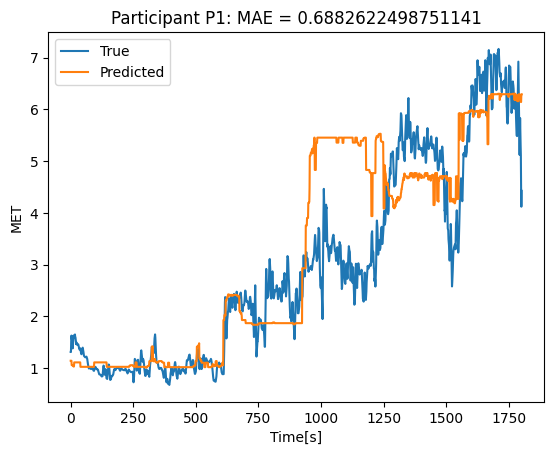

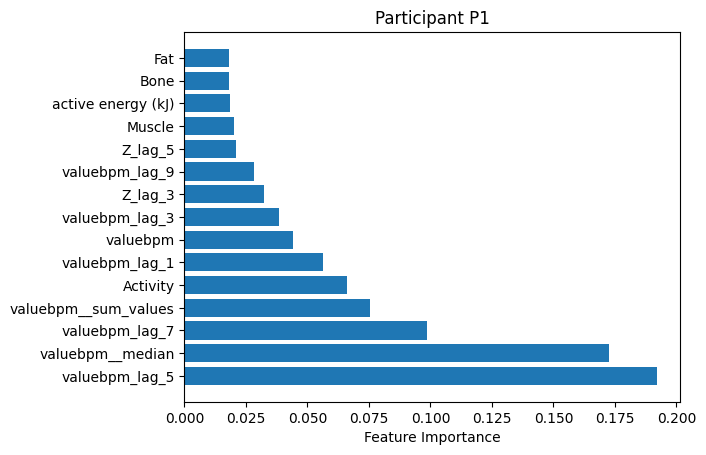

mean MET: true = 2.965399624717587 predicted = 3.2395853996276855, mae =0.27418577491009843


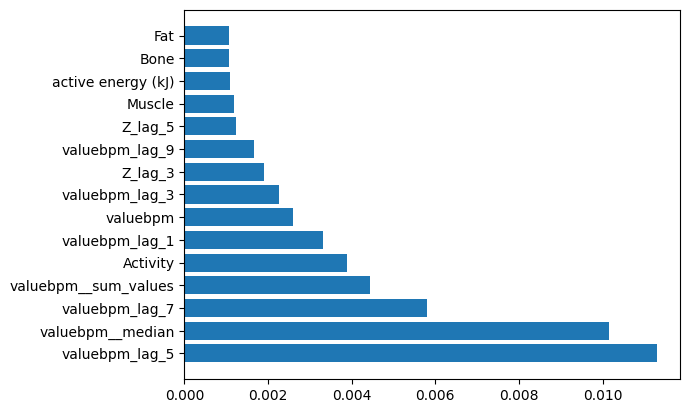

In [25]:
n_top_features = 15
mae_participants = []

feature_importances_all = np.zeros(X.shape[1])
for fold, participant in zip(cv, participants):
    X_train, X_test = X[fold[0]], X[fold[1]]
    y_train, y_test = y[fold[0]], y[fold[1]]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    plt.plot(y_test)
    plt.plot(y_pred)
    plt.title(f"Participant {participant}: MAE = {mae}")
    plt.legend(["True", "Predicted"])
    plt.xlabel("Time[s]")
    plt.ylabel("MET")
    plt.show()

    feature_importances_all += model.feature_importances_
    sorted_idx = model.feature_importances_.argsort()[::-1]
    plt.barh(all_merged_df_selected.columns[sorted_idx][:n_top_features], model.feature_importances_[sorted_idx][:n_top_features])
    plt.xlabel("Feature Importance")
    plt.title(f"Participant {participant}")

    plt.show()

    print(f"mean MET: true = {y_test.mean()} predicted = {y_pred.mean()}, mae ={mean_absolute_error([y_test.mean()],[y_pred.mean()])}")
    mae_participants.append(mse)

    break
    
feature_importances_all /= len(participants_list)
sorted_idx = feature_importances_all.argsort()[::-1]
plt.barh(all_merged_df_selected.columns[sorted_idx][:n_top_features], feature_importances_all[sorted_idx][:n_top_features])
plt.title("Feature Importance")
plt.show()


### Analytics

Text(0.5, 1.0, 'Sensor Importance')

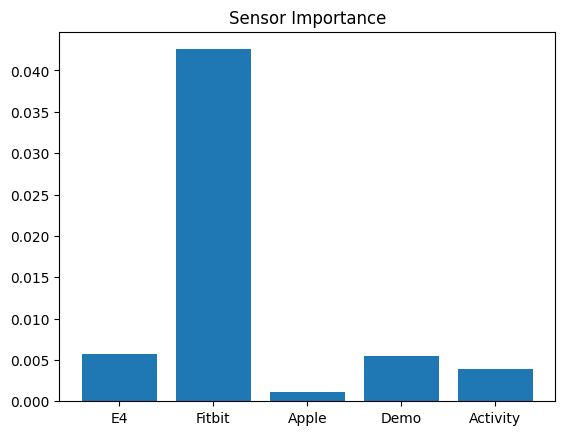

In [27]:
E4_features = ["X", "Y", "Z", "Magnitude"]
Fitbit_features = ["valuebpm", "valueconfidence"]
Apple_features = ["active energy (kJ)"]
Demo_features = ['BMI', 'Fat', 'Muscle','Water', 'Bone', 'Weight', 'Height', 'Age', 'Gender_F', 'Gender_M']
Activity_features = ['Activity']

E_4_indexes = []
Fitbit_indexes = []
Apple_indexes = []
Demo_indexes = []
Activity_indexes = []

#get all colums that contain the string
for i,column in enumerate(all_merged_df_selected.columns):
    for feature in E4_features:
        if feature in column:
            E_4_indexes.append(i)
    for feature in Fitbit_features:
        if feature in column:
            Fitbit_indexes.append(i)
    for feature in Apple_features:
        if feature in column:
            Apple_indexes.append(i)
    for feature in Demo_features:
        if feature in column:
            Demo_indexes.append(i)
    for feature in Activity_features:
        if feature in column:
            Activity_indexes.append(i)


lables = ["E4", "Fitbit", "Apple", "Demo", "Activity"]
summed_contributions = [feature_importances_all[E_4_indexes].sum(), feature_importances_all[Fitbit_indexes].sum(), feature_importances_all[Apple_indexes].sum(), feature_importances_all[Demo_indexes].sum(), feature_importances_all[Activity_indexes].sum()]

plt.bar(lables, summed_contributions)
plt.title("Sensor Importance")



In [28]:
#correlate with demographics 

demographics = pd.read_pickle("preprocessed_dataset/demographics.pkl")
demographics["mae"] = mae_participants

demographics.corr()["mae"]

ValueError: Length of values (1) does not match length of index (17)

## Archive

In [ ]:
# List of models to evaluate, set LGMB to not output info

models = [XGBRegressor()] #LinearRegression(), SVR(), LGBMRegressor(verbose=-1), CatBoostRegressor(verbose=0),
names = ["XGBoost"] #"Linear Regression", "Support Vector Machine", "LightGBM", "CatBoost", 
models_tuned = dict()

# Perform operations for each model
for model,name in zip(models, names):
    model.fit(X_train_scaled, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse}")
    models_tuned[name] = model


In [ ]:
participant = "P3"

X_train, X_test, y_train, y_test = all_merged_df[all_merged_df["Participant"] != participant][X_columns].to_numpy(), all_merged_df[all_merged_df["Participant"] == participant][X_columns].to_numpy(), all_merged_df[all_merged_df["Participant"] != participant]["MET"].to_numpy(), all_merged_df[all_merged_df["Participant"] == participant]["MET"].to_numpy()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = XGBRegressor()
model.fit(X_train_scaled, y_train)
    
# Predict on test data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"{name} Mean Squared Error: {mse}")


In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
)
# Fit the AutoSklearnRegressor
automl.fit(X_train_scaled, y_train)

# Get the predicted values
y_pred = automl.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"AutoSklearn Mean Squared Error: {mse}")

In [ ]:
# Define the TPOTRegressor
tpot = TPOTRegressor(generations=3, population_size=10, verbosity=2, random_state=42, cv = group_kfold.get_n_splits(X, y, participants))

# Fit the TPOTRegressor
tpot.fit(X, y)

# # Get the predicted values
# y_pred = tpot.predict(X_test_scaled)

# # Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print(f"TPOT Mean Squared Error: {mse}")
